# MLP ORF to GenCode 
Train on ORFs, test on GenCode.  
Use the model trained in notebook 113.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-20 16:17:01 UTC


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


## Data Load

In [4]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   
PC_LENS=(200,99000)
NC_LENS=(200,99000)   
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
MAX_K = 3
show_time()

2021-07-20 16:17:24 UTC


In [5]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 106143
NC seqs loaded: 48752
2021-07-20 16:17:32 UTC


In [6]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_length_filter(pcdf,PC_LENS))
nc_all = dataframe_extract_sequence(
    dataframe_length_filter(ncdf,NC_LENS))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-20 16:17:32 UTC
PC seqs pass filter: 105685
NC seqs pass filter: 48469


In [7]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Sequence characteristics:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Sequence characteristics:
PC seqs
Average RNA length: 2301.5303212376402
Average ORF length: 1135.4025074513886
NC seqs
Average RNA length: 1324.391776186841
Average ORF length: 209.12282077203986
2021-07-20 16:18:55 UTC


## Data Prep

In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000


In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGTAGTCTCTTCCAGTTATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAG

In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()

2021-07-20 16:19:12 UTC


## Neural network

In [11]:
best_model=load_model(BESTMODELPATH)
print(best_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               10880     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
Xseq,y=prepare_x_and_y(pc_test,nc_test)
print(Xseq[0])
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[0])
print(y[:5])
X=Xfrq
scores = best_model.evaluate(X, y, verbose=0)
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
CATTCCCAGAAACCAGGAAATTTCTGAAACTGAGTTTTAAACCTGGCAACTCTTTTACCATCCCTTTGTATTTTTGCAGTTCCTCCCTATACCAGCTTCCTTACAGCTGTTCTGATTTCCTGTCGTAAGATTTTTTCTTTTCATTTTCTCCAGGGAGGGTAAATCAATATAACCTCTTCTCTAGAGAGGAGGTGGTTAGGTTGGTCTTAAGCAGTGTTAGAAGATCTATTTTTTTTCAAACCAGGTGTCTGAGCTGGGTGAATTCCAGCCTGGGGAGAGGACTTTGATCACCAGATGTTTTTTTGGTGTGCGTGCTGTCTTATGGTTGCGTGGCGAGTTTCTGCTTCAGATGCAGAGCACTGTCCAGAGCTTCCTCCAGTGGACAATAGCATATTTGTCGCAAAGGAGGTGGAAGGACAGATTCTGGGGACTTACGTTTGTATCAAGGGCTACCACCTGGTAGGAAAGAAGACCCTTTTTTGCAATGCCTCTAAGGAGTGGGATAACACCACTACTGAGTGCCGCTTGGGCCACTGTCCTGATCCTGTGCTGGTGAATGGAGAGTTCAGTTCTTCAGGGCCTGTGAATGTAAGTGACAAAATCACGTTTATGTGCAATGACCACTACATCCTCAAGGGCAGCAATCGGAGCCAGTGTCTAGAGGACCACACCTGGGCACCTCCCTTTCCCATCTGCAAAAGTAGGGACTGTGACCCTCCTGGGAATCCAGTTCATGGCTATTTTGAAGGAAATAACTTCACCTTAGGATCCACCATTAGTTATTACTGTGAAGACAGGTACTA

predictions.shape (16000, 1)
first predictions [[2.1929274e-07]
 [1.7609143e-07]
 [3.5137981e-07]
 [3.6857846e-06]
 [6.3785978e-06]]


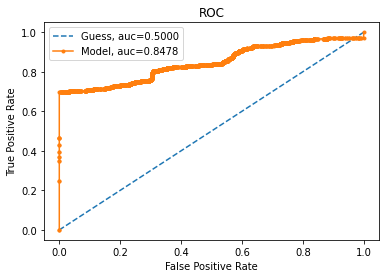

AUC: 84.78%


In [13]:
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first predictions",bm_probs[:5])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))
